In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import to_categorical

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Import DF

In [ ]:
# Loading Essential libraries
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/dataset_preprocessing.csv',) #dataset hasil preprocessing
df.head()

,username,rate,date,label,sentimen,reviews,produk,text_length,anomaly_score,lowercase_reviews,...,no_number_reviews,no_atribut_reviews,no_repetition_reviews,no_whitespace_reviews,no_banned_reviews,no_slang_reviews,clean_reviews,tokens_reviews,stopword_reviews,stem_reviews
0,nadiadiani_,3,19-03-2021 6:58,non,neutral,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",Acnes Creamy Wash,282,1,"ketahuilah apa jenis kulitmu dulu,,utamakan gu...",...,"ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dahulu utamakan g...,ketahuilah apa jenis kulitmu dahulu utamakan g...,"['ketahuilah', 'apa', 'jenis', 'kulitmu', 'dah...","['ketahuilah', 'jenis', 'kulitmu', 'utamakan',...",tahu jenis kulit utama produk kandung hydratin...
1,jiminee10,3,31-08-2022 5:02,fake,neutral,Salah satu facial wash dari drugstore yang lay...,Acnes Creamy Wash,167,1,salah satu facial wash dari drugstore yang lay...,...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,"['salah', 'satu', 'facial', 'wash', 'dari', 'd...","['salah', 'facial', 'wash', 'drugstore', 'laya...",salah facial wash drugstore layak coba busa ku...
2,srihastutik1987,3,2024-05-22 22:24,fake,neutral,Efek:memberikan kulit tampak lebih cerah\n Tek...,MS GLOW FACIAL WASH,103,1,efek:memberikan kulit tampak lebih cerah\n tek...,...,efek:memberikan kulit tampak lebih cerah\n tek...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,"['efek', 'memberikan', 'kulit', 'tampak', 'leb...","['efek', 'kulit', 'cerah', 'tekstur', 'lembut'...",efek kulit cerah tekstur lembut nyaman asli ba...
3,Aisyah_18,3,01-11-2021 11:32,fake,neutral,cukup memuaskan dengan harga yang terjangkau ...,Acnes Creamy Wash,104,1,cukup memuaskan dengan harga yang terjangkau ...,...,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,"['cukup', 'memuaskan', 'dengan', 'harga', 'yan...","['memuaskan', 'harga', 'terjangkau', 'kualitas...",muas harga jangkau kualitas lumayan sedia mark...
4,christinjuniarti,3,29-06-2018 1:01,trusted,neutral,Dr segi packaging sih oke2 aja dan bisa liat w...,Lip Cream LA Girl,431,1,dr segi packaging sih oke2 aja dan bisa liat w...,...,dr segi packaging sih oke aja dan bisa liat w...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dari segi packaging sih oke saja dan bisa liha...,dari segi packaging sih oke saja dan bisa liha...,"['dari', 'segi', 'packaging', 'sih', 'oke', 's...","['segi', 'packaging', 'oke', 'warna', 'produk'...",segi packaging oke warna produk dalam pas dico...


# Modeling - CNN & LSTM - Multi


In [ ]:
max_len = 400  # Max number of words in a sequence
max_features = 20000
# Tokenize the text
df['stem_reviews'] = df['stem_reviews'].astype(str)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['stem_reviews'])
sequences = tokenizer.texts_to_sequences(df['stem_reviews'])

# Pad the sequences
X = pad_sequences(sequences, maxlen=max_len)

# Convert sentiments to numerical labels
sentiment_label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_sentiment = df['sentimen'].map(sentiment_label_map).values

# Convert review labels to numerical labels
review_label_map = {'fake': 0, 'trusted': 1, 'non': 2}
y_review = df['label'].map(review_label_map).values

# Split the data into training and testing sets
X_train, X_test, y_sentiment_train, y_sentiment_test, y_review_train, y_review_test = train_test_split(
    X, y_sentiment, y_review, test_size=0.2, random_state=42
)

## A. Solely Embedding


In [ ]:
print(X_train.shape)  # Harusnya (jumlah_data, max_len)


(1920, 400)


In [ ]:
from keras.models import Model
# Define the model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_features, output_dim=128, input_length=max_len)(input_layer)

# Convolutional layers
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)

# Add Bidirectional LSTM after CNN
bilstm_layer = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(pooling_layer)

# Output layers for both tasks
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(bilstm_layer)
review_output = Dense(3, activation='softmax', name='review_output')(bilstm_layer)

# Compile the model
model = Model(inputs=input_layer, outputs=[sentiment_output, review_output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 400, 128)       │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 396, 128)       │         82,048 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 198, 128)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 256)            │        263,168 │ max_pooling1d[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            771 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ review_output (Dense)     │ (None, 3)              │            771 │ bidirectional[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,906,758 (11.09 MB)

 Trainable params: 2,906,758 (11.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_multitask_model.keras', monitor='val_loss', save_best_only=True)

# Compile the model
model.compile(
    loss={'sentiment_output': 'sparse_categorical_crossentropy', 'review_output': 'sparse_categorical_crossentropy'},
    optimizer='adam',
    metrics={'sentiment_output': 'accuracy', 'review_output': 'accuracy'}
)

# Train the model with the callbacks
history = model.fit(
    X_train, {'sentiment_output': y_sentiment_train, 'review_output': y_review_train},
    epochs=10,
    batch_size=32,
    validation_data=(X_test, {'sentiment_output': y_sentiment_test, 'review_output': y_review_test}),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 957ms/step - loss: 2.0368 - review_output_accuracy: 0.4993 - sentiment_output_accuracy: 0.3635 - val_loss: 1.4473 - val_review_output_accuracy: 0.8021 - val_sentiment_output_accuracy: 0.5271
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 903ms/step - loss: 1.2343 - review_output_accuracy: 0.8645 - sentiment_output_accuracy: 0.6014 - val_loss: 0.7831 - val_review_output_accuracy: 0.9083 - val_sentiment_output_accuracy: 0.7979
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 919ms/step - loss: 0.5578 - review_output_accuracy: 0.9515 - sentiment_output_accuracy: 0.8544 - val_loss: 0.5405 - val_review_output_accuracy: 0.9479 - val_sentiment_output_accuracy: 0.8771
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 894ms/step - loss: 0.2776 - review_output_accuracy: 0.9723 - sentiment_output_accuracy: 0.9421 - val_loss: 0.5296 - val_review_output_accuracy: 0.9563 - val_sentiment_output_accuracy: 0.8875
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 891ms/step - loss: 0.1342 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'review_output_accuracy', 'sentiment_output_accuracy', 'val_loss', 'val_review_output_accuracy', 'val_sentiment_output_accuracy'])


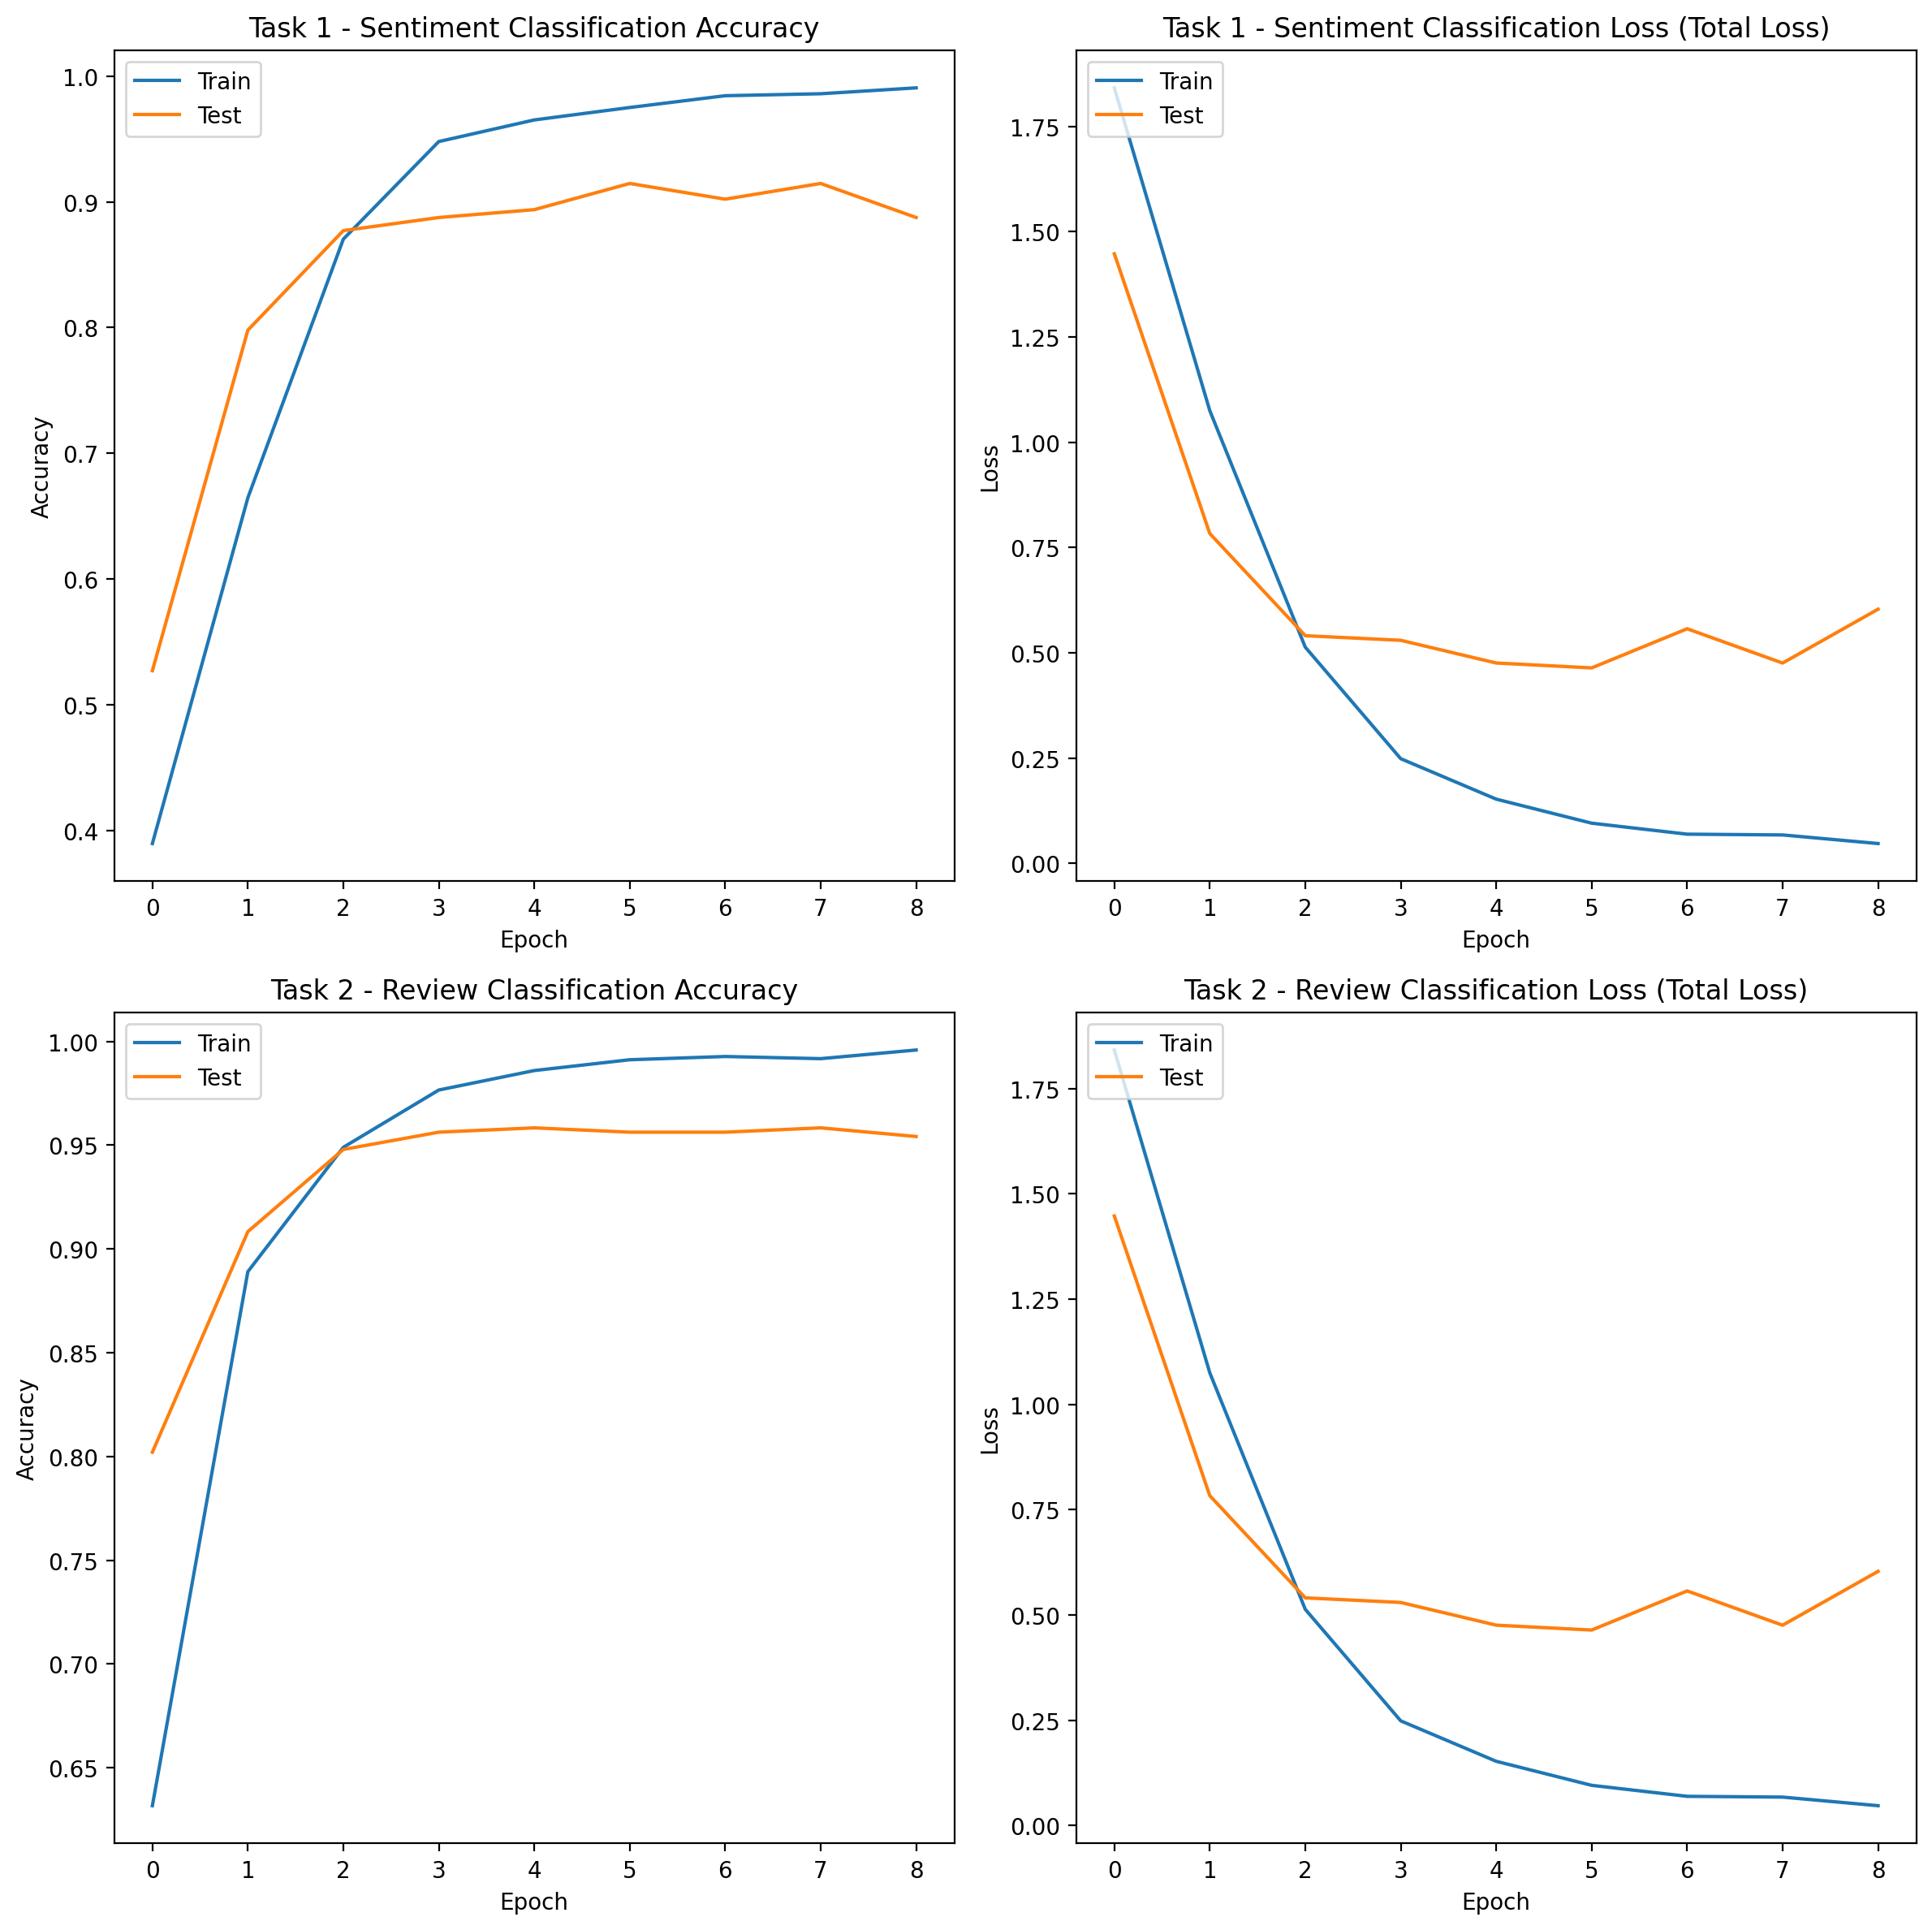

In [ ]:
plt.figure(figsize=(12, 12))

# Plot Task 1 - Klasifikasi Sentimen Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['sentiment_output_accuracy'])
plt.plot(history.history['val_sentiment_output_accuracy'])
plt.title('Task 1 - Sentiment Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot Task 1 - Klasifikasi Sentimen Loss (Menggunakan total loss)
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Task 1 - Sentiment Classification Loss (Total Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot Task 2 - Klasifikasi Review Accuracy
plt.subplot(2, 2, 3)
plt.plot(history.history['review_output_accuracy'])
plt.plot(history.history['val_review_output_accuracy'])
plt.title('Task 2 - Review Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot Task 2 - Klasifikasi Review Loss (Menggunakan total loss)
plt.subplot(2, 2, 4)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Task 2 - Review Classification Loss (Total Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')



plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step
Task 1 - Klasifikasi Sentimen
              precision    recall  f1-score   support

    Negative       0.95      0.92      0.94       157
     Neutral       0.86      0.95      0.90       168
    Positive       0.94      0.87      0.91       155

    accuracy                           0.91       480
   macro avg       0.92      0.91      0.92       480
weighted avg       0.92      0.91      0.91       480

Task 2 - Klasifikasi Review
              precision    recall  f1-score   support

        Fake       0.96      0.91      0.94       163
     Trusted       0.97      0.97      0.97       159
         Non       0.93      0.98      0.96       158

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480

Task 1 Accuracy: 91.46%
Task 2 Accuracy: 95.62%


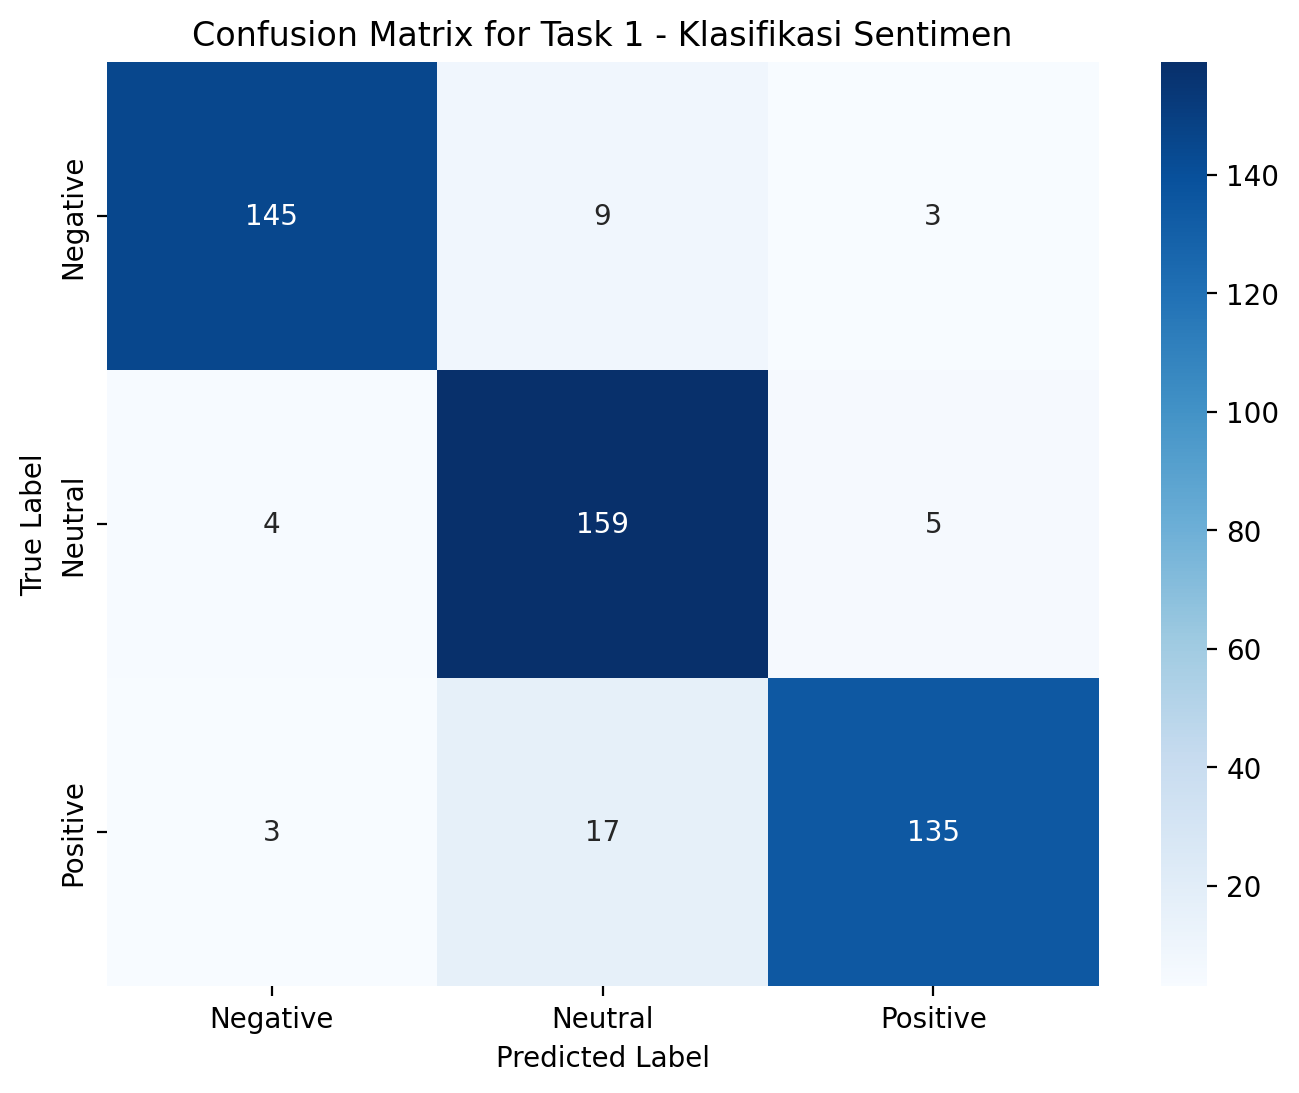

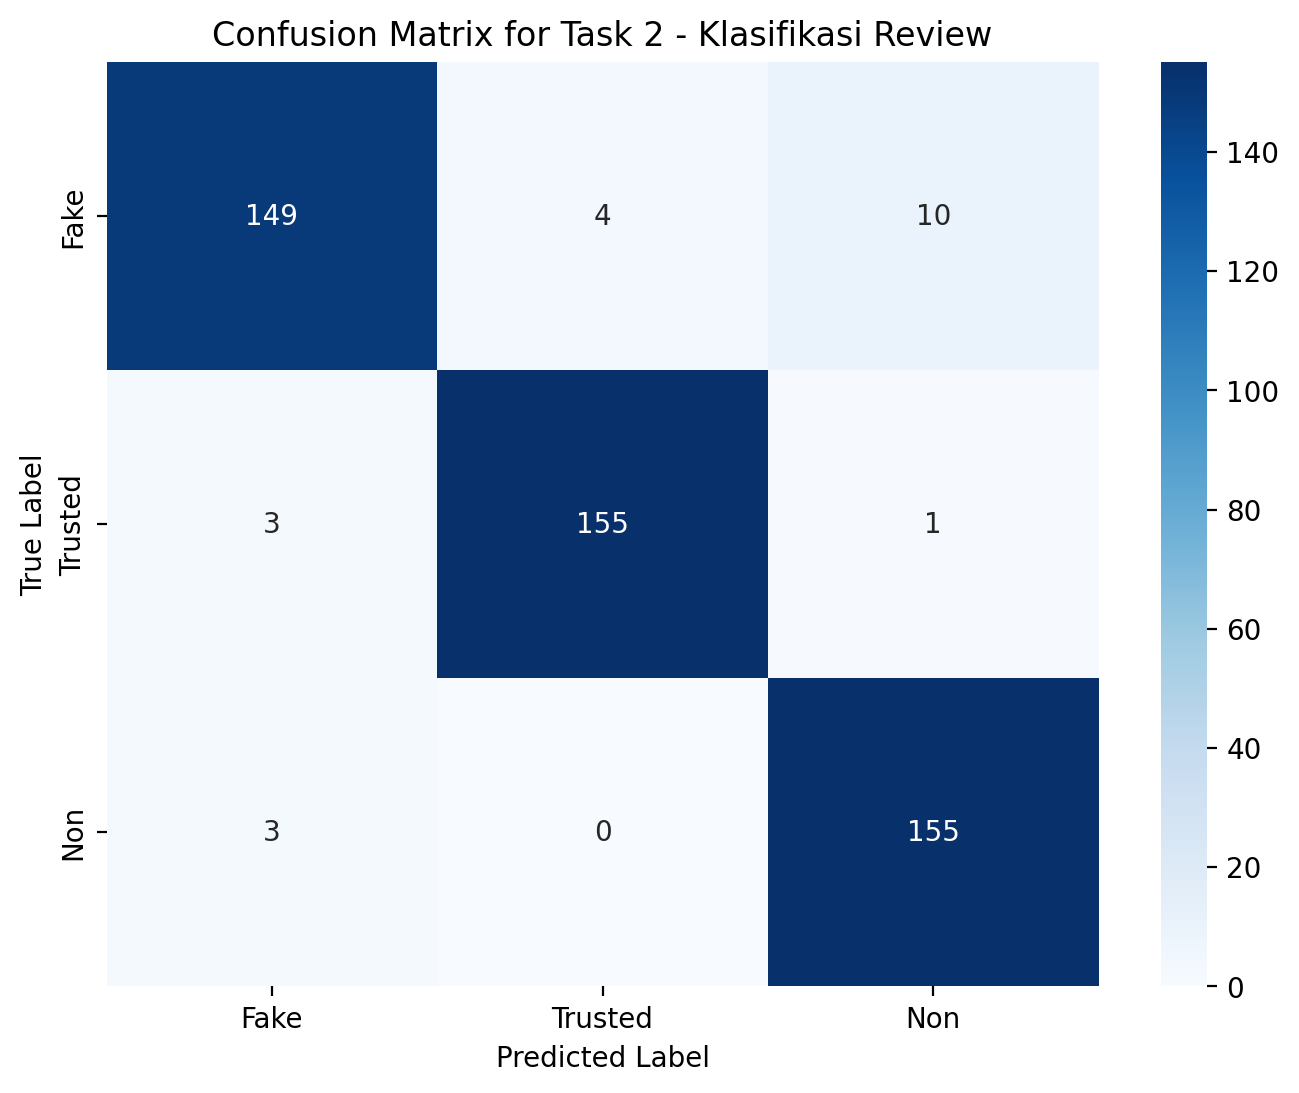

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_multitask(model, X_test, y_test_task1, y_test_task2):
    # Menghasilkan prediksi untuk kedua task
    predictions_task1, predictions_task2 = model.predict(X_test)

    # Konversi hasil prediksi menjadi label
    pred_labels_task1 = np.argmax(predictions_task1, axis=1)
    pred_labels_task2 = np.argmax(predictions_task2, axis=1)

    # Evaluasi Task 1 - Klasifikasi Review
    print("Task 1 - Klasifikasi Sentimen")
    print(classification_report(y_test_task1, pred_labels_task1, target_names=['Negative', 'Neutral', 'Positive']))

    # Evaluasi Task 2 - Klasifikasi Sentimen
    print("Task 2 - Klasifikasi Review")
    print(classification_report(y_test_task2, pred_labels_task2, target_names=['Fake', 'Trusted', 'Non']))

    # Hitung dan cetak akurasi untuk setiap task
    accuracy_task1 = accuracy_score(y_test_task1, pred_labels_task1)
    accuracy_task2 = accuracy_score(y_test_task2, pred_labels_task2)

    print(f"Task 1 Accuracy: {accuracy_task1 * 100:.2f}%")
    print(f"Task 2 Accuracy: {accuracy_task2 * 100:.2f}%")

    # Confusion Matrix untuk Task 1
    cm_task1 = confusion_matrix(y_test_task1, pred_labels_task1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_task1, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title("Confusion Matrix for Task 1 - Klasifikasi Sentimen")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Confusion Matrix untuk Task 2
    cm_task2 = confusion_matrix(y_test_task2, pred_labels_task2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_task2, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Trusted', 'Non'], yticklabels=['Fake', 'Trusted', 'Non'])
    plt.title("Confusion Matrix for Task 2 - Klasifikasi Review")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return y_test_task1, pred_labels_task1, y_test_task2, pred_labels_task2

# Panggil fungsi evaluasi untuk mendapatkan hasil
true_labels_task1, predictions_task1, true_labels_task2, predictions_task2 = evaluate_model_multitask(
    model, X_test, y_sentiment_test, y_review_test
)


## B. Glove

In [ ]:
import numpy as np
import gensim.downloader as api

# Load the GloVe model (trained on English)
glove_model = api.load('glove-wiki-gigaword-100')  # 100-dimensional GloVe embeddings

embedding_dim = 100  # Since we are using 'glove-wiki-gigaword-100', the dimension is 100

# Create an embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_features:
        try:
            embedding_vector = glove_model[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            pass

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# Define the model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_features,
                            output_dim=embedding_dim,
                            input_length=max_len,
                            weights=[embedding_matrix],
                            trainable=False)(input_layer)

# Convolutional layers
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)

# Add Bidirectional LSTM after CNN
bilstm_layer = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(pooling_layer)

# Output layers for both tasks
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(bilstm_layer)
review_output = Dense(3, activation='softmax', name='review_output')(bilstm_layer)

# Compile the model
model_B = Model(inputs=input_layer, outputs=[sentiment_output, review_output])
model_B.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_B.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 400)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 400, 100)       │      2,000,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 396, 128)       │         64,128 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 198, 128)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        263,168 │ max_pooling1d_1[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            771 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ review_output (Dense)     │ (None, 3)              │            771 │ bidirectional_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,328,838 (8.88 MB)

 Trainable params: 328,838 (1.25 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_multitask_model.keras', monitor='val_loss', save_best_only=True)

# Compile the model
model_B.compile(
    loss={'sentiment_output': 'sparse_categorical_crossentropy', 'review_output': 'sparse_categorical_crossentropy'},
    optimizer='adam',
    metrics={'sentiment_output': 'accuracy', 'review_output': 'accuracy'}
)

# Train the model with the callbacks
history_B = model_B.fit(
    X_train, {'sentiment_output': y_sentiment_train, 'review_output': y_review_train},
    epochs=10,
    batch_size=32,
    validation_data=(X_test, {'sentiment_output': y_sentiment_test, 'review_output': y_review_test}),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 848ms/step - loss: 1.9954 - review_output_accuracy: 0.5726 - sentiment_output_accuracy: 0.3767 - val_loss: 1.4534 - val_review_output_accuracy: 0.8167 - val_sentiment_output_accuracy: 0.5437
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 801ms/step - loss: 1.3406 - review_output_accuracy: 0.8345 - sentiment_output_accuracy: 0.6274 - val_loss: 1.2018 - val_review_output_accuracy: 0.8833 - val_sentiment_output_accuracy: 0.6333
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 826ms/step - loss: 1.0334 - review_output_accuracy: 0.8899 - sentiment_output_accuracy: 0.7260 - val_loss: 0.8773 - val_review_output_accuracy: 0.9000 - val_sentiment_output_accuracy: 0.7625
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 800ms/step - loss: 0.7503 - review_output_accuracy: 0.9121 - sentiment_output_accuracy: 0.8052 - val_loss: 0.7346 - val_review_output_accuracy: 0.9208 - val_sentiment_output_accuracy: 0.7896
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 786ms/step - loss: 0.5356 

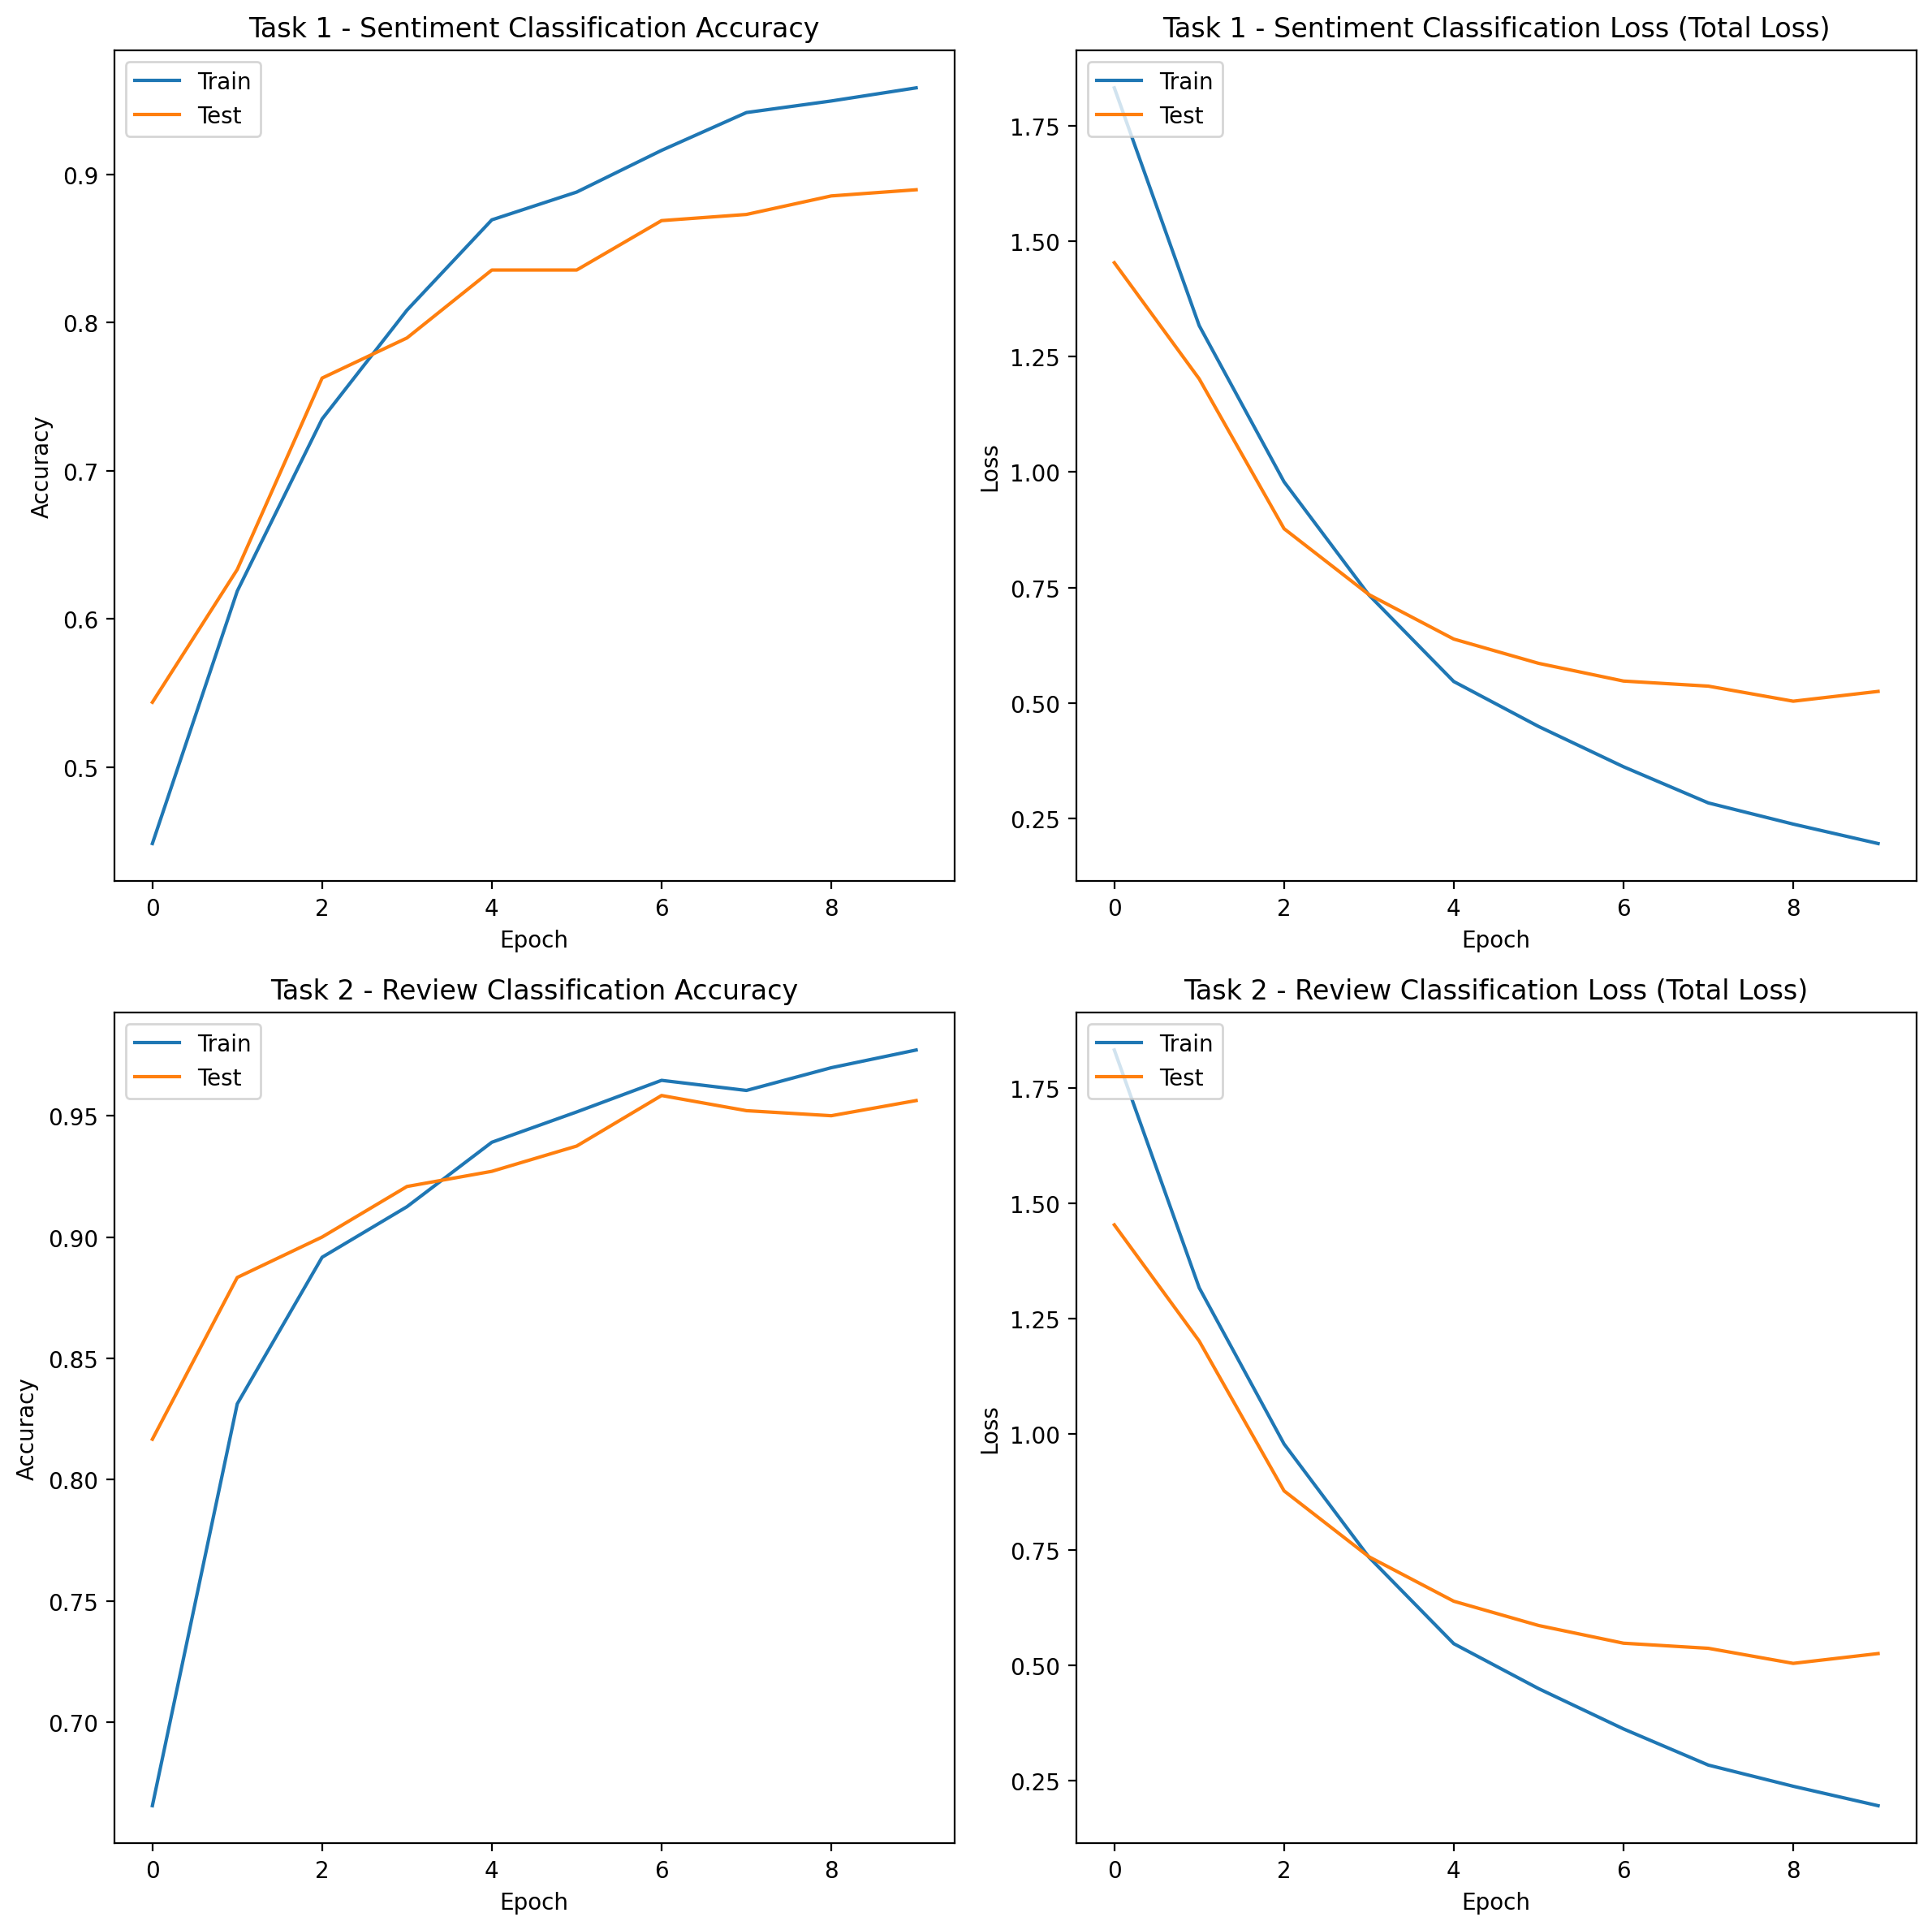

In [ ]:
plt.figure(figsize=(12, 12))

# Plot Task 1 - Klasifikasi Sentimen Accuracy
plt.subplot(2, 2, 1)
plt.plot(history_B.history['sentiment_output_accuracy'])
plt.plot(history_B.history['val_sentiment_output_accuracy'])
plt.title('Task 1 - Sentiment Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot Task 1 - Klasifikasi Sentimen Loss (Menggunakan total loss)
plt.subplot(2, 2, 2)
plt.plot(history_B.history['loss'])
plt.plot(history_B.history['val_loss'])
plt.title('Task 1 - Sentiment Classification Loss (Total Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot Task 2 - Klasifikasi Review Accuracy
plt.subplot(2, 2, 3)
plt.plot(history_B.history['review_output_accuracy'])
plt.plot(history_B.history['val_review_output_accuracy'])
plt.title('Task 2 - Review Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot Task 2 - Klasifikasi Review Loss (Menggunakan total loss)
plt.subplot(2, 2, 4)
plt.plot(history_B.history['loss'])
plt.plot(history_B.history['val_loss'])
plt.title('Task 2 - Review Classification Loss (Total Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')



plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step
Task 1 - Klasifikasi Sentimen
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.88       157
     Neutral       0.92      0.84      0.88       168
    Positive       0.86      0.95      0.90       155

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480

Task 2 - Klasifikasi Review
              precision    recall  f1-score   support

        Fake       0.96      0.91      0.93       163
     Trusted       0.97      0.97      0.97       159
         Non       0.92      0.97      0.94       158

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480

Task 1 Accuracy: 88.54%
Task 2 Accuracy: 95.00%


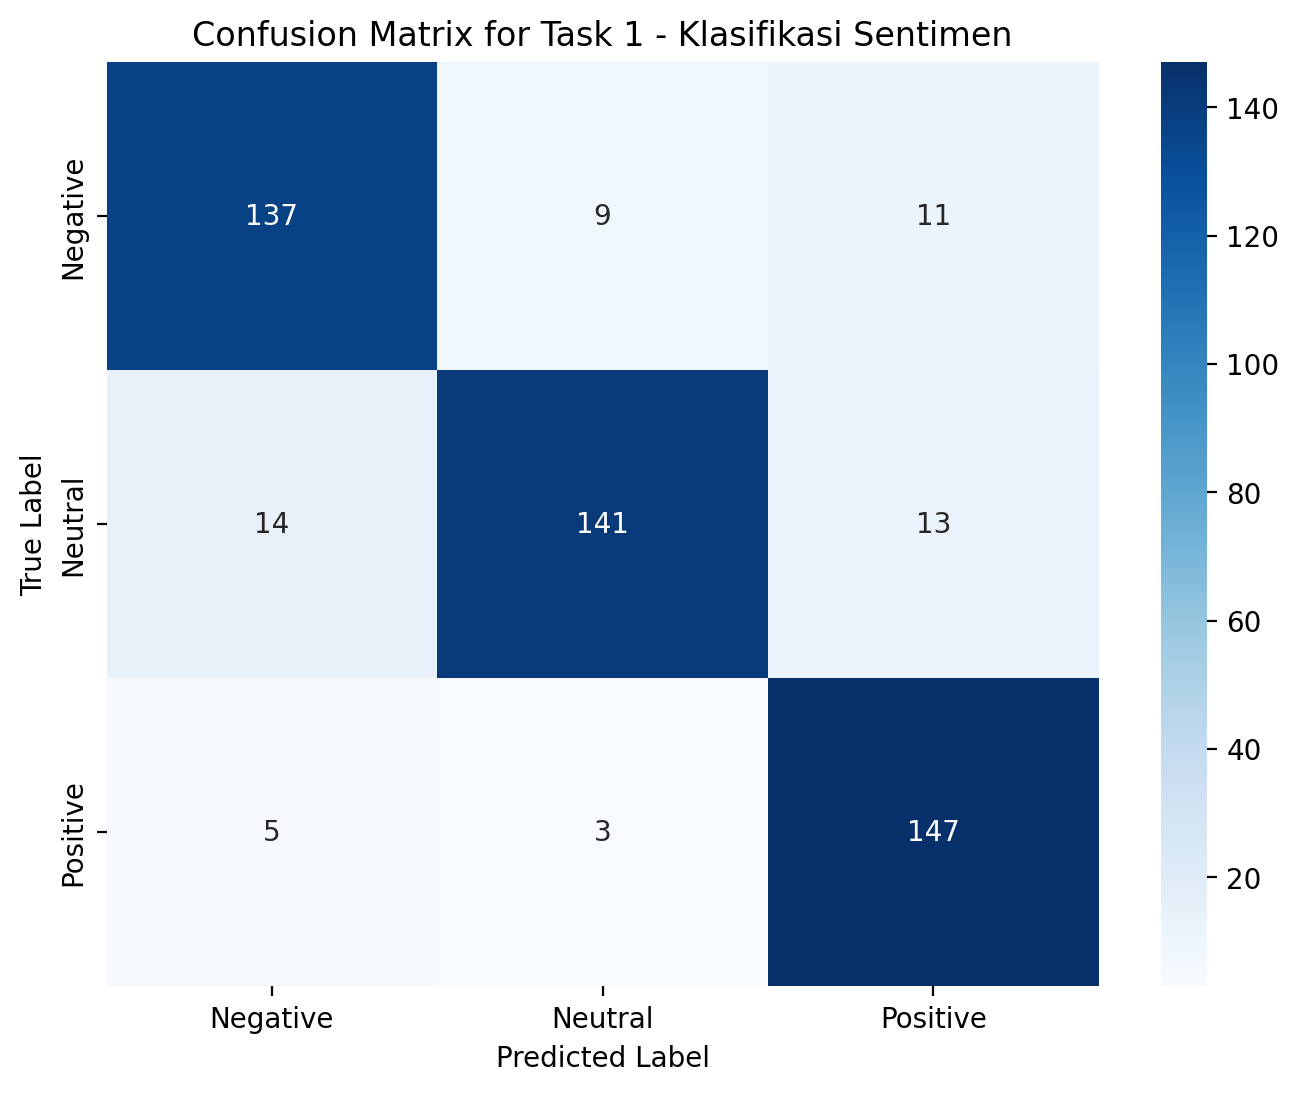

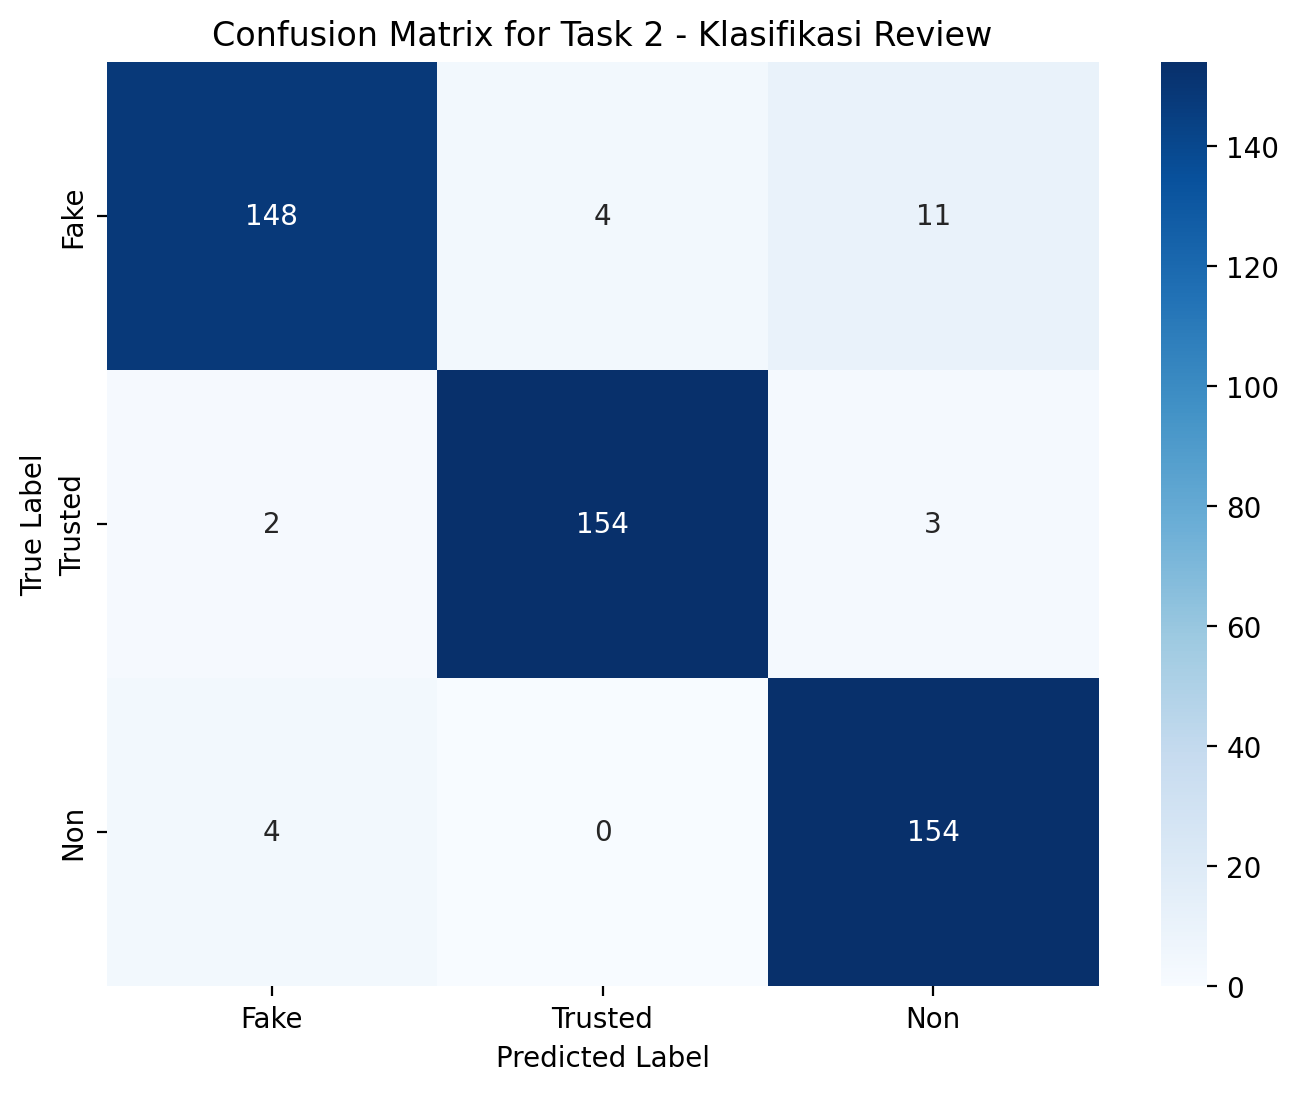

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_multitask(model, X_test, y_test_task1, y_test_task2):
    # Menghasilkan prediksi untuk kedua task
    predictions_task1, predictions_task2 = model_B.predict(X_test)

    # Konversi hasil prediksi menjadi label
    pred_labels_task1 = np.argmax(predictions_task1, axis=1)
    pred_labels_task2 = np.argmax(predictions_task2, axis=1)

    # Evaluasi Task 1 - Klasifikasi Review
    print("Task 1 - Klasifikasi Sentimen")
    print(classification_report(y_test_task1, pred_labels_task1, target_names=['Negative', 'Neutral', 'Positive']))

    # Evaluasi Task 2 - Klasifikasi Sentimen
    print("Task 2 - Klasifikasi Review")
    print(classification_report(y_test_task2, pred_labels_task2, target_names=['Fake', 'Trusted', 'Non']))

    # Hitung dan cetak akurasi untuk setiap task
    accuracy_task1 = accuracy_score(y_test_task1, pred_labels_task1)
    accuracy_task2 = accuracy_score(y_test_task2, pred_labels_task2)

    print(f"Task 1 Accuracy: {accuracy_task1 * 100:.2f}%")
    print(f"Task 2 Accuracy: {accuracy_task2 * 100:.2f}%")

    # Confusion Matrix untuk Task 1
    cm_task1 = confusion_matrix(y_test_task1, pred_labels_task1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_task1, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title("Confusion Matrix for Task 1 - Klasifikasi Sentimen")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Confusion Matrix untuk Task 2
    cm_task2 = confusion_matrix(y_test_task2, pred_labels_task2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_task2, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Trusted', 'Non'], yticklabels=['Fake', 'Trusted', 'Non'])
    plt.title("Confusion Matrix for Task 2 - Klasifikasi Review")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return y_test_task1, pred_labels_task1, y_test_task2, pred_labels_task2

# Panggil fungsi evaluasi untuk mendapatkan hasil
true_labels_task1, predictions_task1, true_labels_task2, predictions_task2 = evaluate_model_multitask(
    model, X_test, y_sentiment_test, y_review_test
)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def evaluate_model_multitask(model, X_test, y_test_task1, y_test_task2):
    # Menghasilkan prediksi untuk kedua task
    predictions_task1, predictions_task2 = model.predict(X_test)

    # Konversi hasil prediksi menjadi label
    pred_labels_task1 = np.argmax(predictions_task1, axis=1)
    pred_labels_task2 = np.argmax(predictions_task2, axis=1)

    # Evaluasi Task 1 - Klasifikasi Review
    print("Task 1 - Klasifikasi Review (Trusted, Fake, Non)")
    print(classification_report(y_test_task1, pred_labels_task1, target_names=['Fake', 'Trusted', 'Non']))

    # Evaluasi Task 2 - Klasifikasi Sentimen
    print("Task 2 - Klasifikasi Sentimen (Negative, Neutral, Positive)")
    print(classification_report(y_test_task2, pred_labels_task2, target_names=['Negative', 'Neutral', 'Positive']))

    # Hitung dan cetak akurasi untuk setiap task
    accuracy_task1 = accuracy_score(y_test_task1, pred_labels_task1)
    accuracy_task2 = accuracy_score(y_test_task2, pred_labels_task2)

    print(f"Task 1 Accuracy: {accuracy_task1 * 100:.2f}%")
    print(f"Task 2 Accuracy: {accuracy_task2 * 100:.2f}%")

    return y_test_task1, pred_labels_task1, y_test_task2, pred_labels_task2

# Panggil fungsi evaluasi untuk mendapatkan hasil
true_labels_task1, predictions_task1, true_labels_task2, predictions_task2 = evaluate_model_multitask(
    model, X_test, y_sentiment_test, y_review_test
)



15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step
Task 1 - Klasifikasi Review (Trusted, Fake, Non)
              precision    recall  f1-score   support

        Fake       0.95      0.92      0.94       157
     Trusted       0.86      0.95      0.90       168
         Non       0.94      0.87      0.91       155

    accuracy                           0.91       480
   macro avg       0.92      0.91      0.92       480
weighted avg       0.92      0.91      0.91       480

Task 2 - Klasifikasi Sentimen (Negative, Neutral, Positive)
              precision    recall  f1-score   support

    Negative       0.96      0.91      0.94       163
     Neutral       0.97      0.97      0.97       159
    Positive       0.93      0.98      0.96       158

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480

Task 1 Accuracy: 91.46%
Task 2 Accuracy: 95.62%


In [ ]:
from keras.models import load_model

def predict_multitask(text, model, tokenizer, max_len):
    # Tokenize the input text
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    # Predict the sentiment and review classification
    prediction_sentiment, prediction_review = model.predict(padded_sequences)

    # Sentiment Prediction
    predicted_class_sentiment = prediction_sentiment.argmax(axis=1)[0]
    confidence_sentiment = prediction_sentiment[0][predicted_class_sentiment] * 100

    # Map the predicted class to the sentiment label
    sentiment_label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_label_sentiment = sentiment_label_map[predicted_class_sentiment]

    # Review Classification Prediction
    predicted_class_review = prediction_review.argmax(axis=1)[0]
    confidence_review = prediction_review[0][predicted_class_review] * 100

    # Map the predicted class to the review label
    review_label_map = {0: 'fake', 1: 'trusted', 2: 'non'}
    predicted_label_review = review_label_map[predicted_class_review]

    return (predicted_label_sentiment, confidence_sentiment), (predicted_label_review, confidence_review)

# Load the tokenizer and model
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['stem_reviews'])  # Ensure the tokenizer is fitted on the training data
best_model = load_model('best_multitask_model.keras')

In [ ]:
# Example usage
text = input("Enter the text to analyze: ")
(sentiment_label, sentiment_confidence), (review_label, review_confidence) = predict_multitask(text, best_model, tokenizer, max_len)

print(f'Text: {text}')
print(f'Predicted Sentiment: {sentiment_label} (Confidence: {sentiment_confidence:.2f}%)')
print(f'Predicted Review Classification: {review_label} (Confidence: {review_confidence:.2f}%)')